# Fashion Image Classification on Maryland Polyvore: Fourth Scenario - AutoEncoder

In this project, we implement an autoencoder model to process and reconstruct images from a custom dataset sourced from Polyvore. Our primary objective is to explore how an autoencoder can be utilized for image representation and potential applications in fashion recommendations. The Polyvore dataset can be accessed [here](https://github.com/AemikaChow/AiDLab-fAshIon-Data/blob/main/Datasets/cleaned-maryland.)

## Authors
- Kamand Kalashi
- Sajjad Saed

## Project Overview

The project consists of several critical steps, including data loading, preprocessing, model architecture design, training, and evaluation. Below is a summary of the steps involved:

### 1. Dataset Preparation
- The dataset consists of fashion images organized into folders based on their respective class labels.
- Each image is read, resized to 128x128 pixels, and converted to grayscale.
- The images are normalized and split into training, validation, and test sets to ensure proper model training and evaluation.

### 2. Autoencoder Architecture
An autoencoder is built with the following architecture:
- **Input Layer**: Receives images flattened into a vector.
- **Encoder**:
  - Dense layer with 64 units and ReLU activation.
  - Batch normalization and dropout layers to enhance performance and reduce overfitting.
- **Decoder**:
  - Dense layer reconstructing the input image.
  - Final layer with sigmoid activation to output pixel values.

### 3. Model Compilation
The autoencoder is compiled with:
- **Optimizer**: Adam with a learning rate of 0.001258.
- **Loss Function**: Binary cross-entropy, suitable for image reconstruction tasks.

### 4. Model Training
The model is trained over 50 epochs with a batch size of 128. The training data is augmented using various transformations (e.g., rotations, shifts, flips) to increase diversity and robustness, enhancing model performance.

### 5. Evaluation
After training, the autoencoder is evaluated by comparing original images with their reconstructed versions. The reconstruction quality is visually assessed using Matplotlib. The classification model, built on top of the autoencoder features, is evaluated using accuracy metrics, confusion matrices, and classification reports.

### 6. Results Visualization
- A series of plots illustrate the training and validation accuracy and loss over epochs.
- Confusion matrices are generated to evaluate the model's performance on the test set, highlighting specific classes where the model could improve.

## Requirements
To run this project, ensure you have the following libraries installed:
- NumPy
- OpenCV
- TensorFlow
- Keras
- Matplotlib
- Seaborn

## Conclusions
This project demonstrates how autoencoders can effectively extract meaningful features from fashion images, aiding in both reconstruction and classification tasks. The data augmentation significantly enhanced model performance by preventing overfitting, resulting in a model capable of classifying fashion images effectively. Future work could explore integrating the autoencoder with a recommendation engine to enhance user experience in fashion selection while further optimizations and tuning may improve results in specific classes identified during evaluation.

## Importing Required Libraries

In [1]:
# Importing required libraries
# Feature extraction and feature selection
import numpy as np

# imqage processing and visualization
import cv2
import tqdm as tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Data training and create cnn model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
import keras
from keras import layers
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import itertools
import ipywidgets as widgets

## 1. Dataset Preparation
Prepares the fashion images by reading, resizing, and normalizing them, as well as splitting the dataset into training, validation, and test sets.

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = '/content/drive/MyDrive/Polyvore/'

In [6]:
# return dataset class names and count
def get_class_names(data_path):
    class_names = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    return class_names

In [7]:
# get dataset class names and count
class_names = get_class_names(dataset_path)
print("Dataset class count:", len(class_names)," and names are:", class_names)

Dataset class count: 8  and names are: ['bag', 'dress', 'eyewear', 'hats', 'neckwear', 'pants', 'shoes', 'watches']


In [8]:
# to resizing all data to same size (128*128)
image_size = 128
# Array to store all images with its label
all_data = []
image_count = []
count = 0

# For each index in the list of classes (class_names), by using method join with arguments dataset_path and i,
# reads all images of these classes and after resizing to 12*128, store the image with its label in all_data array
for i in class_names:
  path=os.path.join(dataset_path,i)
  class_label = class_names.index(i)
  for image in tqdm.tqdm(os.listdir(path)):
    try:
      image_array=cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
      new_image_array = cv2.resize(image_array, (image_size, image_size))
      all_data.append([new_image_array, class_label])
      # plt.imshow(new_image_array)
      # plt.show()
      # break
      if os.path.isfile(os.path.join(path,image)):
        count += 1
    except Exception as e:
      pass
  image_count.append([count, class_names[class_label]])
  count = 0
image_count

100%|██████████| 786/786 [00:08<00:00, 91.27it/s] 


[[786, 'bag'],
 [800, 'dress'],
 [780, 'eyewear'],
 [782, 'hats'],
 [791, 'neckwear'],
 [793, 'pants'],
 [789, 'shoes'],
 [786, 'watches']]

In [9]:
len(all_data)

6307

In [10]:
# split images and labels to X and Y arays
# images
X = []
# labels
Y = []
for i, j in all_data:
  X.append(i)
  Y.append(j)
# reshape images to 128*128 and channel 1 (black & white )
X = np.array(X).reshape(-1, image_size, image_size)
print(X.shape)
# to normalize
X = X/255
X = X.reshape(-1, image_size, image_size, 1)
print(X.shape)

# Converts class vector (Y) to binary class matrix --> one hot encoding
Y = tf.keras.utils.to_categorical(Y,num_classes = 10)

(6307, 128, 128)
(6307, 128, 128, 1)


In [11]:
# split the all_data into 80% train data and 20% test data by random state 42
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 101, shuffle = True)
# split 15% of the train data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 101, shuffle = True)

In [12]:
print('all data:', len(all_data))
print('total train data:', len(X_train) , 'and shape:', X_train.shape)
print('total validation data:', len(X_val), 'and shape:', X_val.shape)
print('total test data:', len(X_test), 'and shape:', X_test.shape)

all data: 6307
total train data: 4288 and shape: (4288, 128, 128, 1)
total validation data: 757 and shape: (757, 128, 128, 1)
total test data: 1262 and shape: (1262, 128, 128, 1)


In [13]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(4288, 16384)
(1262, 16384)


## 2. Autoencoder Architecture
Defines the architecture of the autoencoder model, consisting of an encoder and decoder.

In [15]:
from keras.layers import BatchNormalization

# Define the autoencoder model
encoding_dimantion = 64
input_size = keras.Input(shape=(image_size*image_size,))
encoded = layers.Dense(encoding_dimantion, activation='relu')(input_size)
encoded = BatchNormalization()(encoded)

encoded = tf.keras.layers.Dropout(0.2)(encoded)
# encoded = tf.keras.layers.Dropout(0.2)(encoded)

# maps an input to its encoded representation
encoder = keras.Model(input_size, encoded)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(encoding_dimantion, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)

encoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = layers.Dense(image_size*image_size, activation='sigmoid')(encoded)
# maps an input to its reconstruction
autoencoder = keras.Model(input_size, decoded)

In [16]:
# encoded input (32-dimensional)
encoded_input = keras.Input(shape=(encoding_dimantion,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

## 3. Model Compilation
Compiles the autoencoder with a specified optimizer and loss function.

In [17]:
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# Compile the autoencoder model for classification
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001258, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

## 4. Model Training
Trains the autoencoder model over 50 epochs, applying data augmentation to enhance model robustness.

In [18]:
# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
34/34 [==============================] - 7s 33ms/step - loss: 0.6796 - val_loss: 0.6538
Epoch 2/50
34/34 [==============================] - 1s 17ms/step - loss: 0.5860 - val_loss: 0.4817
Epoch 3/50
34/34 [==============================] - 1s 17ms/step - loss: 0.3635 - val_loss: 0.2380
Epoch 4/50
34/34 [==============================] - 1s 17ms/step - loss: 0.1671 - val_loss: 0.1062
Epoch 5/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0808 - val_loss: 0.0585
Epoch 6/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0492 - val_loss: 0.0397
Epoch 7/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0357 - val_loss: 0.0309
Epoch 8/50
34/34 [==============================] - 1s 18ms/step - loss: 0.0290 - val_loss: 0.0263
Epoch 9/50
34/34 [==============================] - 1s 18ms/step - loss: 0.0252 - val_loss: 0.0235
Epoch 10/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0229 - val_loss: 0.0218
Epoch 11/

## 5. Evaluation
Evaluates the model by comparing original and reconstructed images and generates performance metrics.

In [19]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

40/40 [==============================] - 0s 1ms/step


In [20]:
decoded_imgs[0].shape

(16384,)

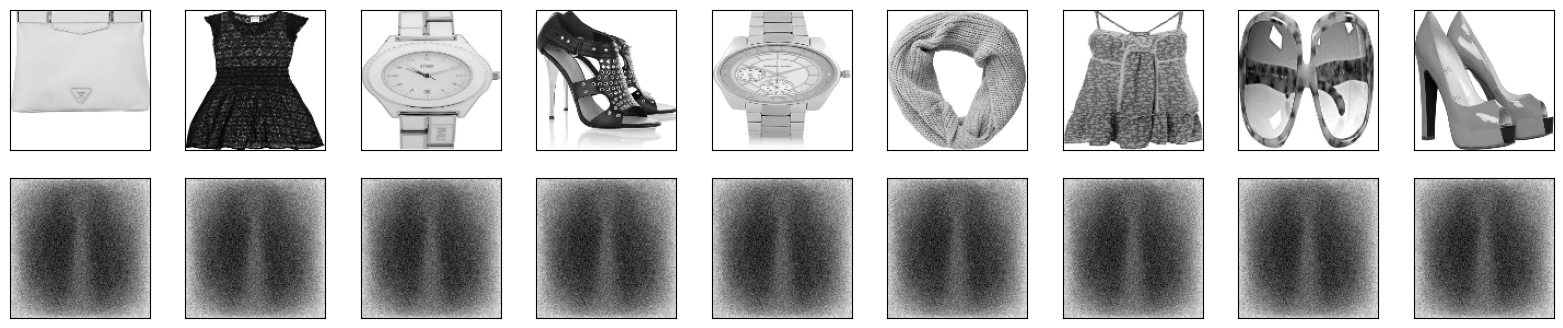

In [21]:
# Display original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(9):
    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 9, i + 1 + 9)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
len(X_train.shape)

4

In [23]:
len(X_test)

1262

In [24]:
# The X_train is our original data with shape (num_samples, height, width, channels)
# If data is grayscale, add a channel dimension
if len(X_train.shape) == 3:
    X_train = np.expand_dims(X_train, axis=-1)

# ImageDataGenerator for augmentation
train_datagen_augmented =  keras.preprocessing.image.ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    featurewise_std_normalization=False,
    samplewise_center=False,
    samplewise_std_normalization=False,
    fill_mode='nearest'
    )

# Flow from the augmented data generator
train_generator_augmented = train_datagen_augmented.flow(X_train, y_train, batch_size=len(X_train), shuffle=False)

# Get the augmented data
X_train_augmented, y_train_augmented = train_generator_augmented.next()

In [25]:
# to normilize data
X_train_augmented = X_train_augmented /255

In [26]:
# Concatenate augmented data with the original data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))

In [27]:
X_train_combined.shape

(8576, 128, 128, 1)

In [28]:
# new_all_data = np.concatenate((all_data, X_train_combined))
# print('all data:', len(new_all_data))
print('total train data:', len(X_train_combined) , 'and shape:', X_train_combined.shape)
print('total validation data:', len(X_val), 'and shape:', X_val.shape)
print('total validation data:', len(X_test), 'and shape:', X_test.shape)

total train data: 8576 and shape: (8576, 128, 128, 1)
total validation data: 757 and shape: (757, 128, 128, 1)
total validation data: 1262 and shape: (1262, 128, 128, 1)


In [29]:
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
# My CNN architecture
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu', input_shape = (image_size, image_size, 1)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))  # Dropout to reduce overfitting
# model.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_2 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0

In [30]:
# Configures the model for training.
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001275, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7), metrics = ['accuracy'])

In [31]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 4, verbose = 1, mode = 'auto', factor = 0.3, min_lr = 0.000001)
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DL_project_CNN_from_scratch.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 4, mode = 'max')

In [32]:
# Train the model with data augmentation
train_datagen_augmented.fit(X_train_combined)
mycnn_history = model.fit_generator(train_datagen_augmented.flow(X_train_combined, y_train_combined, batch_size = 32),
                              epochs = 40,
                              validation_data = (X_val, y_val),
                              steps_per_epoch = X_train_combined.shape[0] // 32,
                              # validation_steps=X_val.shape[0] // 32,
                              callbacks = [reduce_learning_rate, tensorboard, checkpoint])

<ipython-input-32-b05b9b9d0617>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mycnn_history = model.fit_generator(train_datagen_augmented.flow(X_train_combined, y_train_combined, batch_size = 32),


Epoch 1/40
268/268 [==============================] - ETA: 0s - loss: 2.1048 - accuracy: 0.1458
Epoch 1: val_accuracy improved from -inf to 0.19551, saving model to DL_project_CNN_from_scratch.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


268/268 [==============================] - 23s 65ms/step - loss: 2.1048 - accuracy: 0.1458 - val_loss: 39.0219 - val_accuracy: 0.1955 - lr: 0.0010
Epoch 2/40
268/268 [==============================] - ETA: 0s - loss: 1.9922 - accuracy: 0.1903
Epoch 2: val_accuracy improved from 0.19551 to 0.33289, saving model to DL_project_CNN_from_scratch.h5
268/268 [==============================] - 18s 66ms/step - loss: 1.9922 - accuracy: 0.1903 - val_loss: 52.1770 - val_accuracy: 0.3329 - lr: 0.0010
Epoch 3/40
267/268 [============================>.] - ETA: 0s - loss: 1.9184 - accuracy: 0.2252
Epoch 3: val_accuracy did not improve from 0.33289
268/268 [==============================] - 16s 61ms/step - loss: 1.9180 - accuracy: 0.2255 - val_loss: 94.3557 - val_accuracy: 0.3276 - lr: 0.0010
Epoch 4/40
268/268 [==============================] - ETA: 0s - loss: 1.8774 - accuracy: 0.2386
Epoch 4: val_accuracy did not improve from 0.33289
268/268 [==============================] - 17s 62ms/step - loss: 1

In [33]:
# Save the Model
model.save('DL_project_auto_encoder2.h5')

## 6. Results Visualization
Visualizes training and validation accuracy and loss, as well as confusion matrices for model evaluation.

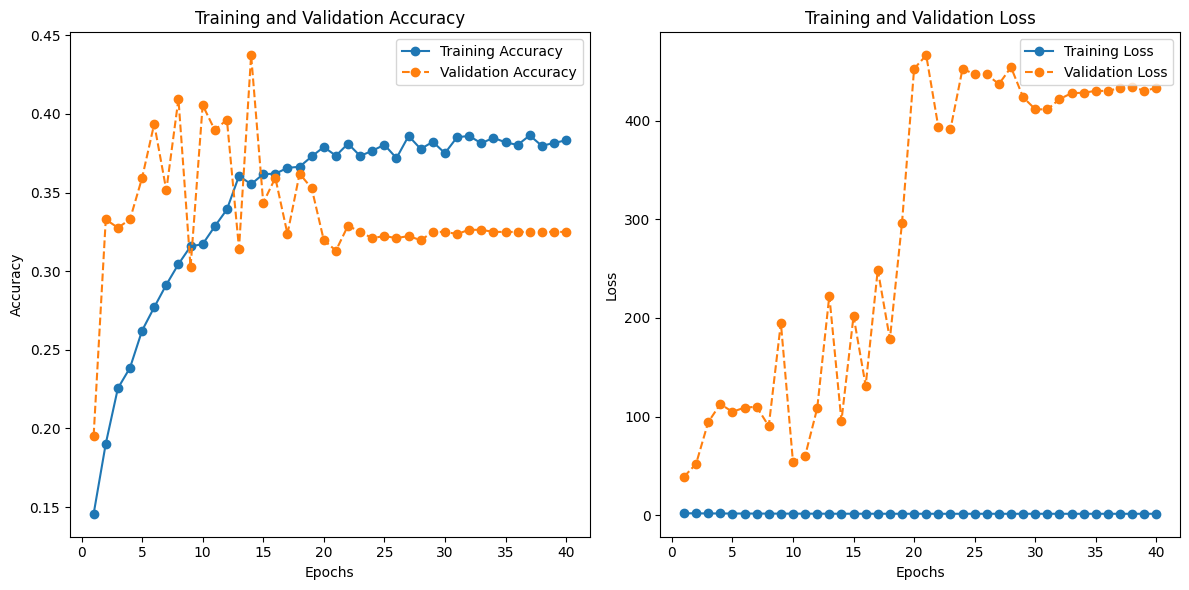

In [34]:
import matplotlib.pyplot as plt

# Displaying curves of loss and accuracy during training
acc = mycnn_history.history['accuracy']
val_acc = mycnn_history.history['val_accuracy']
loss = mycnn_history.history['loss']
val_loss = mycnn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy on the left side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='dashed')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss on the right side
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=mycnn_history.history['val_loss'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Validation_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=mycnn_history.history['loss'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Training_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=mycnn_history.history['val_accuracy'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Validation_accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=mycnn_history.history['accuracy'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Training_accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of CNN Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Loss</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Accuracy</b>", secondary_y=True)

fig.show()

In [36]:
# Evaluate the model  --> first method
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_real = np.argmax(y_test, axis = 1)

# display result of evaluate the model  --> first method
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
print(f"Test loss: {test_loss: 0.2f}")

# display result of evaluate the model  --> first method
accuracy = np.sum(y_pred == y_real) / len(y_test)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

40/40 [==============================] - 1s 12ms/step - loss: 0.7218 - accuracy: 0.7583
Test accuracy: 75.83%
Test loss:  0.72
Test accuracy: 75.83%


In [37]:
print(classification_report(y_real, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bag       0.68      0.79      0.73       169
       dress       0.72      0.78      0.75       157
     eyewear       0.80      0.99      0.88       144
        hats       0.73      0.71      0.72       168
    neckwear       0.88      0.55      0.68       165
       pants       0.88      0.92      0.89       153
       shoes       0.72      0.56      0.63       158
     watches       0.71      0.82      0.76       148

    accuracy                           0.76      1262
   macro avg       0.76      0.76      0.76      1262
weighted avg       0.76      0.76      0.75      1262



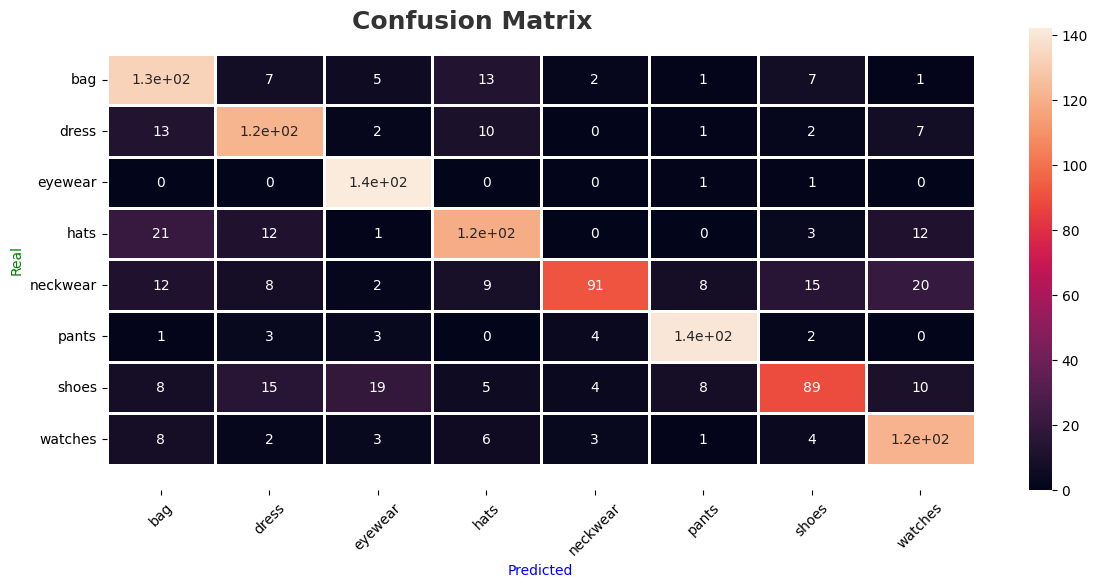

In [38]:
# display confusion matrix
fig, ax = plt.subplots(1,1,figsize=(14, 6))
sns.heatmap(confusion_matrix(y_real, y_pred), xticklabels=class_names, yticklabels=class_names,annot=True, linewidths=2, linecolor='white', ax=ax)
fig.text(s="Confusion Matrix", size=18,fontweight='bold', fontname='DejaVu Sans', y=0.88,x=0.30,alpha=0.8)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted', color='blue')
plt.ylabel('Real', color='green')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
# plt.show()